In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

### We use the following expression to solve the self-consistent gap equation. 
[StackExchange Link](https://physics.stackexchange.com/questions/54200/superconducting-gap-temperature-dependence-how-to-calculate-this-integral)

$$\eta \approx \int_{0}^{\delta^{-1}\sinh\eta}\tanh\left(0.882 \frac{\delta}{\tau}\sqrt{1+z^{2}}\right)\frac{dz}{\sqrt{1+z^{2}}}
$$

Where,

$\delta=\Delta(T)/\Delta_{0}$, $\eta = \frac{1}{N(0)V}
$ and $\tau = T / T_{c}$
<br>
<br>
#### Basic Idea(Algorithm)
 - We fix $\eta$ for the whole run. The typical value for eta is around ~ 3
 - We then fix $\delta$ and let the solver run to find the value of $\tau$ for which L.H.S($\eta$) is equal to the R.H.S (the integration). Numerically we fix a tolerance value for this. 
 - We then change the $\delta$ and repeat the above step to get another $\tau$
 - This way we get $\delta(\tau)$ which then we can plot

In [2]:
@numba.jit(nopython=True)
def fn(x,delta=0.5,tau=0.5):
    """
    Defines the function in the integrand.
    
    :Params
    delta : default value is 0.5
    tau : default value is 0.5
    """
    
    return np.sqrt((1/(1+ x ** 2))) * np.tanh(0.882 * (delta/tau) * np.sqrt(1 + x ** 2))

In [3]:
def plot_fn(delta=0.5,tau=0.5):
    """
    Plots the function defined in fn(x)
    """
    x = np.linspace(0.01,1,100)
    y = fn(x)
    plt.plot(x,y)
    plt.xlabel(r"$\tau$")
    plt.ylabel("f(x)")
    plt.show()
    

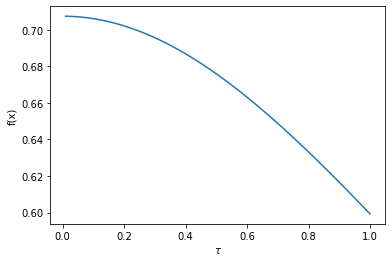

In [4]:
plot_fn()

In [5]:
@numba.jit(nopython=True)
def simpsons_int(delta,tau = 0.5,eta = 3.2):
    """
    Evaluates the integration of the function fn(x) in the limit a to b for given value of 
    delta, tau and eta
    
    :Params
    delta : no default value is provided
    tau : default value is 0.5
    eta : default value is 3.2
    """
    
    a = 0
    b = (np.sinh(eta)/delta)
    n = 1000
    h = (b-a)/n
    x = np.linspace(a,b,n+1)
    y = fn(x,delta,tau)
    I_simp = h/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])
    
    return I_simp
    

In [6]:
@numba.jit(nopython=True)
def find_min_tau(delta,eta=3.2):
    """
    Finds the minimum value of tau for a given delta  which satisfies the self-consistency relation. 
    
    Since the variation is almost flat for large range of values,the self-consistent condition is satisfied
    for multiple values which gets repeated for different deltas. Hence for a one-to-one mapping we take
    minimum value. 
    
    :params
    delta : no default value
    eta : default value is 3.2
    
    """
    tau_list = []
    for i in range(0,100):
        tau = 0.0001 + 0.01*i
        eps = abs(eta - simpsons_int(delta, tau))
        if eps < 0.01:
            tau_list.append(tau)
    return min(tau_list)
    

In [7]:
@numba.jit(nopython=True)
def solver(n_delta = 500):
    delta = np.linspace(0.999,0.1,n_delta)
    taus =[]
    deltas =[]
    for values in delta: #iterating over different values of deltas
        min_ = find_min_tau(values)
        if min_ not in taus: # so that we only have unique set of points
            taus.append(min_)
            deltas.append(values)
    return taus, deltas

In [8]:
def plot_result():
    #-----adding end point data
    taus.insert(0,0) # at tau =0; delta = 1
    taus.insert(len(taus),1) #at tau = 1, delta=0
    deltas.insert(0,1)
    deltas.insert(len(deltas),0)
    #-----
    plt.figure(figsize=(8,4), tight_layout=True)
    plt.plot(taus,deltas,'r-.',label=r"$\delta(\tau)$",linewidth=3.0)
    plt.xlabel(r"$\tau$",fontsize=18)
    plt.ylabel(r"$\delta$",fontsize=18)
    plt.legend(prop={'size': 15})
    plt.grid()
    plt.show()

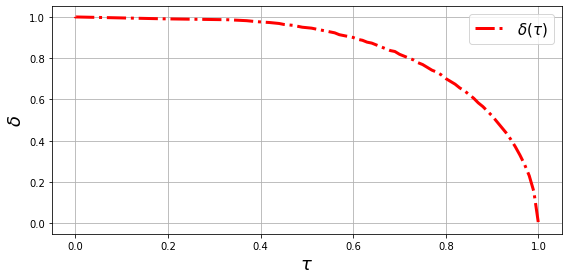

In [10]:
taus, deltas = solver(n_delta=200)
plot_result()